In [1]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ttest_rel
from tqdm import tqdm

from dataloader import FastTensorDataLoader

## Data Generation

In [2]:
def generate_samples(mean, std, m, n):
    """
    Generate a list of samples drawn from a normal distribution.

    Args:
        mean (float): Mean of the normal distribution.
        std (float): Standard deviation of the normal distribution.
        m (int): Number of samples to generate.
        n (int): Number of elements in each sample.

    Returns:
        list[torch.Tensor]: A list of `m` tensors, each of shape (n, 1).
    """
    samples = []
    for _ in range(m):
        sample = torch.normal(mean=mean, std=std, size=(n,))
        sample = sample.unsqueeze(-1)  # Add the extra dimension
        samples.append(sample.clone())
    return samples

In [3]:
mean, std = 0, 2
m, n = 100, 1000
samples = generate_samples(mean, std, m, n)

In [4]:
train_size = int(0.8 * m)
test_size = m - train_size  # To ensure total matches `m`

X = torch.stack(samples, dim=0)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=32, shuffle=False)
loader_test = FastTensorDataLoader(X_test, batch_size=32, shuffle=False)


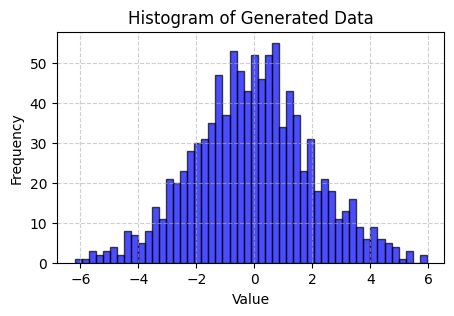

In [5]:
plt.figure(figsize=(5, 3))
plt.hist(X_train[0].numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Model

In [6]:
class Gaussian_1d(nn.Module):
    def __init__(self):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.randn(1, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.abs(torch.randn(1, dtype=torch.float64)))

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2 / self.sigma**2)

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x).sum()
        psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
        return psi

    def loss(self, x_t):
        lengths = len(x_t)

        if not isinstance(x_t, torch.Tensor):
            x_t = torch.tensor(x_t, dtype=torch.float32)

        x_t = x_t.clone().detach().requires_grad_(True)
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)

        divergence = 0
        for i in range(x_t.shape[-1]):
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, create_graph=True)[0]
            divergence += gradient[..., i]

        total_loss = 0.5 * norm_squared + divergence

        # Real value calculations
        psi_x_real = -(x_t - self.mu) / self.sigma**2
        norm_squared_real = (psi_x_real ** 2).sum(dim=-1)
        divergence_real = -1 / self.sigma**2

        real_loss = 0.5 * norm_squared_real + divergence_real

        # Average across batch
        total_loss = total_loss.sum() / lengths
        real_loss = real_loss.sum() / lengths

        return total_loss.mean(), real_loss.mean()


In [7]:
def optimize_theta_gaussian(
    loader_train, num_epochs=1000, learning_rate=1e-3,
):
    model = Gaussian_1d()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

    losses, real_losses = [], []
    estimated_mus = []
    estimated_stds = []

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for _ in pbar:
        epoch_loss = 0.0
        epoch_real_loss = 0.0
        num_batches = 0

        start_time = time.time()
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss, real_loss = model.loss(X_batch[0])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_real_loss += real_loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        epoch_real_loss /= num_batches

        losses.append(epoch_loss)
        real_losses.append(epoch_real_loss)
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_stds.append(model.sigma.detach().numpy().copy())

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{epoch_loss:.4f}",
            "Real Loss": f"{epoch_real_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    return model, losses, real_losses, estimated_mus, estimated_stds


In [8]:
epochs = 100
model, losses, real_losses, estimated_mu, estimated_std = optimize_theta_gaussian(
    loader_train, num_epochs=epochs, learning_rate=1e-2)

Training: 100%|██████████| 100/100 [00:01<00:00, 54.42epoch/s, Train Loss=-125.2654, Real Loss=-125.2654, Time/Epoch=0.02s]


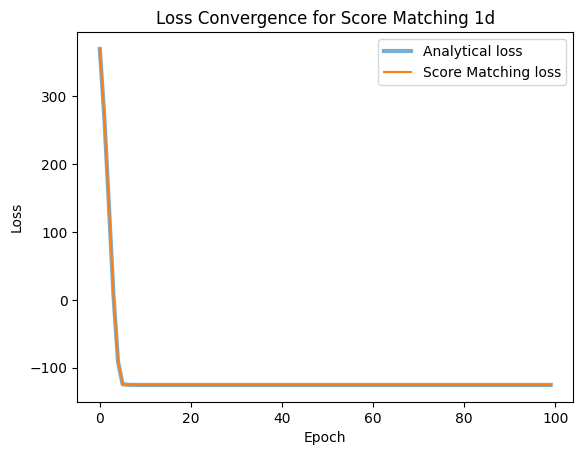

In [9]:
plt.plot(real_losses, linewidth=3, alpha=0.6, label="Analytical loss")
plt.plot(losses, label="Score Matching loss", linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching 1d')
plt.legend()
plt.show()

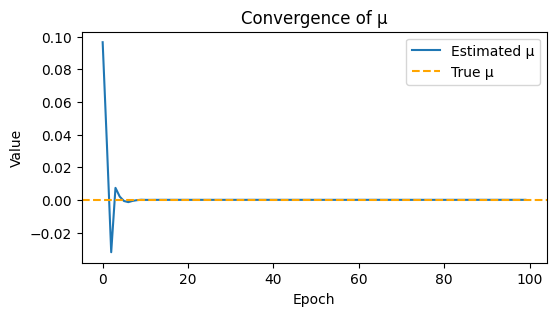

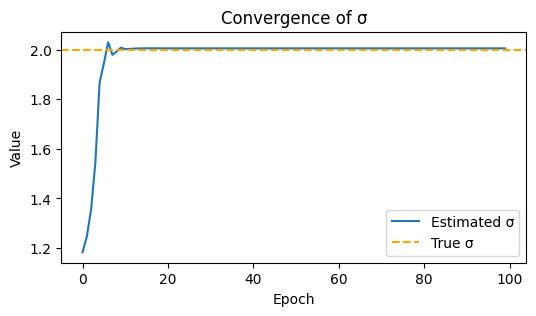

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(estimated_mu, label="Estimated μ")
plt.axhline(mean, color='orange', linestyle='--', label="True μ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(estimated_std, label="Estimated σ")
plt.axhline(std, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [11]:
print("Final estimated μ:", estimated_mu[-1][0])
print("True μ:", mean)
print("\nFinal estimated σ:\n", estimated_std[-1][0])
print("True σ:\n", std)

Final estimated μ: 1.863620696734167e-05
True μ: 0

Final estimated σ:
 2.004687512183757
True σ:
 2


## Statistical Testing

In [14]:
num_trials = 100
epochs = 100
learning_rate = 1e-2
m, n = 100, 1000

true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [15]:
json_file = 'data/trial_results.json'

In [16]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

for trial in tqdm(range(num_trials), desc="Running trials"):
    mean = np.random.uniform(1, 5)
    std = np.random.uniform(1, 3)
    
    samples = generate_samples(mean, std, m, n)
    X = torch.stack(samples, dim=0)
    loader_train = FastTensorDataLoader(X, batch_size=32, shuffle=False)

    _, _, _, estimated_mu, estimated_std = optimize_theta_gaussian(
        loader_train, num_epochs=epochs, learning_rate=learning_rate)
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr": learning_rate,
        "true_mean": mean,
        "true_std": std,
        "estimated_mean": estimated_mu[-1][0].item(),
        "estimated_std": estimated_std[-1][0].item()
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials: 100%|██████████| 100/100 [06:31<00:00,  3.91s/it]


In [17]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mean'] for trial in trial_results])
true_cov = np.array([trial['true_std'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mean'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_std'] for trial in trial_results])

In [18]:
mean_ttest = ttest_rel(true_mu, estimated_mu)
std_ttest = ttest_rel(true_cov, estimated_cov)

print(f"Mean difference (paired t-test): p-value = {mean_ttest.pvalue}")
print(f"Variance difference (paired t-test): p-value = {std_ttest.pvalue}")

alpha = 0.05
if mean_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated means.")
else:
    print("No statistically significant difference in estimated means.")

if std_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated variances.")
else:
    print("No statistically significant difference in estimated variances.")

Mean difference (paired t-test): p-value = 0.7409132520923929
Variance difference (paired t-test): p-value = 0.8751214788594812
No statistically significant difference in estimated means.
No statistically significant difference in estimated variances.
